In [36]:
import cv2
import mediapipe as mp
import os


def cutout_face(file: str, save_folder: str) -> tuple[int, int, int, int]:
    """Detect face in an image and return its size (width x height)"""

    # Initialize mediapipe face detection
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(min_detection_confidence=0.2)

    # Read image
    image = cv2.imread(file)
    height, width, _ = image.shape

    # Convert the BGR image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Process image and get the results
    results = face_detection.process(image_rgb)

    if results.detections and len(results.detections) == 1:
        # Assuming the first detection is the most prominent face
        face = results.detections[0].location_data.relative_bounding_box
        
        face = image[
            int(face.ymin * height):int((face.ymin+face.height) * height),
            int(face.xmin * width):int((face.xmin+face.width) * width),
        ]
        dir_name = os.path.basename(os.path.dirname(file))
        os.makedirs(os.path.join(save_folder, dir_name), exist_ok=True)
        cv2.imwrite(os.path.join(save_folder, dir_name, os.path.basename(file)), face)


In [37]:
cutout_face("/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/imdb_crop/00/nm0000100_rm3755520000_1955-1-6_2011.jpg", "/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/imdb_fixed")

In [19]:
import scipy
data = scipy.io.loadmat("/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/imdb/imdb.mat")

In [101]:
from datetime import datetime, timedelta
from tqdm import tqdm
import numpy as np


def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    hours = days % 1 * 24
    minutes = hours % 1 * 60
    seconds = minutes % 1 * 60
    return datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)


def convert_to_age(datenum, photo_year) -> int:
    date_of_birth = datenum_to_datetime(datenum)
    photo_year = datetime(year=int(photo_year), month=6, day=1)
    return (photo_year - date_of_birth).days // 365

filtered_data = []

db_folder = "/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/imdb_fixed"
for date_of_birth, photo_year, name, gender, file_path in tqdm(zip(
    data["imdb"]["dob"][0][0][0],
    data["imdb"]["photo_taken"][0][0][0],
    data["imdb"]["name"][0][0][0],
    data["imdb"]["gender"][0][0][0],
    data["imdb"]["full_path"][0][0][0],
)):
    try:
        age = convert_to_age(date_of_birth, photo_year)
    except OverflowError:
        continue
    name = name[0]
    file_path = file_path[0]
    if gender == 0:
        gender = "female"
    elif gender == 1:
        gender = "male"
    else:
        gender = None

    if not os.path.exists(os.path.join(db_folder, file_path)):
        continue
    
    filtered_data.append({
        "file_path": file_path,
        "age": age,
        "name": name,
        "gender": gender,
    })


460723it [00:06, 71221.89it/s]


In [85]:
len(filtered_data)

318225

In [102]:
import pandas as pd

df = pd.DataFrame(filtered_data)

In [103]:
df.head(10)

,file_path,age,name,gender
0,01/nm0000001_rm124825600_1899-5-10_1968.jpg,69,Fred Astaire,male
1,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,71,Fred Astaire,male
2,01/nm0000001_rm577153792_1899-5-10_1968.jpg,69,Fred Astaire,male
3,01/nm0000001_rm946909184_1899-5-10_1968.jpg,69,Fred Astaire,male
4,01/nm0000001_rm980463616_1899-5-10_1968.jpg,69,Fred Astaire,male
5,02/nm0000002_rm1075631616_1924-9-16_1991.jpg,66,Lauren Bacall,female
6,02/nm0000002_rm1346607872_1924-9-16_2004.jpg,79,Lauren Bacall,female
7,02/nm0000002_rm1363385088_1924-9-16_2004.jpg,79,Lauren Bacall,female
8,02/nm0000002_rm1411175936_1924-9-16_1991.jpg,66,Lauren Bacall,female
9,02/nm0000002_rm1646056960_1924-9-16_1991.jpg,66,Lauren Bacall,female


<Axes: xlabel='age'>

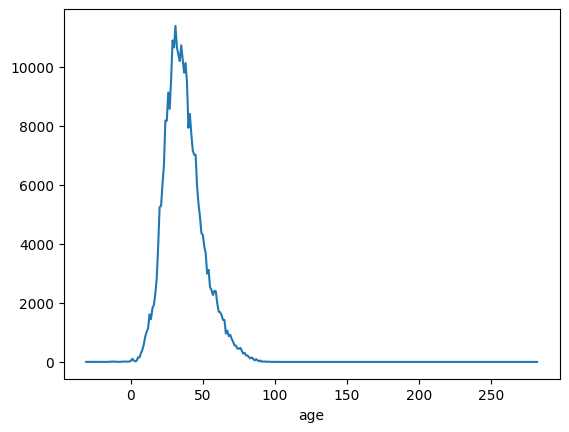

In [107]:
df["age"].value_counts().sort_index().plot()

<Axes: xlabel='age'>

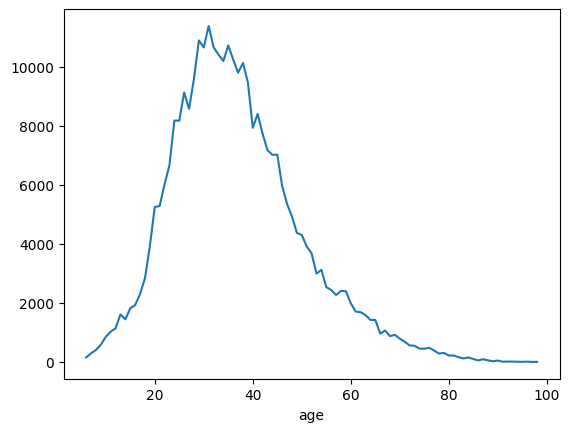

In [108]:
df = df[df["age"] < 100]
df = df[df["age"] > 5]
df["age"].value_counts().sort_index().plot()

In [109]:
df["gender"].value_counts()

gender
male      181946
female    130247
Name: count, dtype: int64

In [120]:
print(df["age"].mean())
df["age"].std()

36.80451262742333


13.149257383643812

In [111]:
train = df.sample(frac=0.8)
df_left = df.drop(train.index)
val = df_left.sample(frac=0.5)
test = df_left.drop(val.index)

train.to_parquet("/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/train.parquet", index=False)
val.to_parquet("/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/val.parquet", index=False)
test.to_parquet("/home/simonexc/Documents/GitHub/age-detect-app/data/train_data/test.parquet", index=False)

In [117]:
df.iloc[0]["age"]

68